<a href="https://colab.research.google.com/github/bradleywjenks/CIVE_70019_70057/blob/main/notebooks/pressure_control.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parameter estimation for hydraulic model calibration and fault detection


### CIVE 70019/70057
Department of Civil and Environmental Engineering, Imperial College London

### Preamble
This notebook implements sequential convex programming (SCP) to estimate roughness coefficients for hydraulic model calibration. The following steps should be performed to calibrate the hydraulic model:
1. Load network properties and operational data
2. Analyse preliminary model performance
3. Introduce sequential convex programming (SCP) algorithm to solve nonlinear parameter estimation problem
4. Part 1: parameter estimation of pipe roughness (or Hazen-Williams) coefficients **without** pipe grouping/regularisation
5. Part 2: parameter estimation of pipe roughness (or Hazen-Williams) coefficients **with** pipe grouping/regularisation
6. Part 3: parameter estimation of pipe roighness (or Hazen-Williams) coefficients **with** pipe grouping/regularisation **and** valve loss coefficients

Each step should be followed by a brief discussion on your assumptions and the caibration results.

First, we must clone the GitHub repository and install dependencies (only run this once).

In [1]:
# Run this cell once
import sys
import os

if 'google.colab' in sys.modules:
  !git clone https://github.com/bradleywjenks/CIVE_70019_70057.git
  !pip install wntr
  !apt-get install libsuitesparse-dev && pip install scikit-sparse
  !pip install cvxpy
  !pip install -q pyomo
  !pip install --upgrade idaes-pse
  !idaes get-extensions

In [2]:
# Load packages
import numpy as np
from numpy import linalg as la
import networkx as nx
import pandas as pd
import wntr
import matplotlib.pyplot as plt
import copy
from datetime import datetime, timedelta
import warnings
import matplotlib.cm as cm
from pyomo.environ import *
from pyomo.opt import SolverFactory
import idaes
import cvxpy as cp
warnings.filterwarnings('ignore')

# improve matplotlib image quality
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

Select modelling language for optimisation in Python.

In [3]:
model = 'cvxpy' # 'cvxpy' or 'pyomo'

### Load network properties and operational data

Load functions created in previous assignments.

In [4]:
# change directory to src functions
if 'google.colab' in sys.modules:
    %cd '/content/CIVE_70019_70057/src/'
else:
    os.chdir('/home/bradw/workspace/CIVE_70019_70057/src/')

# load src functions
import general_functions as gen_fn
import hydraulic_functions as hyd_fn

# change back to parent directory
if 'google.colab' in sys.modules:
    %cd '/content/CIVE_70019_70057/'
else:
    os.chdir('/home/bradw/workspace/CIVE_70019_70057/')

Load network .inp file and operational data from the module repository's data directory.

In [5]:
if 'google.colab' in sys.modules:
    # if run in Google Colab
    data_dir = '/content/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/content/CIVE_70019_70057/data/networks/'
else:
    # replace with local directory
    data_dir = '/home/bradw/workspace/CIVE_70019_70057/data/parameter_estimation/'
    net_dir = '/home/bradw/workspace/CIVE_70019_70057/data/networks/'

net_name = 'stkl_calib.inp'
data_name = 'stkl_coursework_dataset.npy'

# load operational data
data = np.load(os.path.join(data_dir, data_name), allow_pickle=True).item()
h_data = data['h_data']
sensor_idx = data['sensor_idx']
inflow_data = data['inflow'].reshape(-1, 1).T
h0_data = data['h0'].reshape(-1, 1).T

# load network properties
wdn = gen_fn.load_network_data(os.path.join(net_dir, net_name))
A12 = wdn.A12
A10 = wdn.A10
net_info = wdn.net_info
link_df = wdn.link_df
node_df = wdn.node_df
demand_df = wdn.demand_df

Plot sensor nodes in network. Make a function for this to call throughout the file.

In [6]:
# define plotting function using networkx
def plot_network(wdn, sensor_idx, vals=None, highlight_valves=None):

    # unload data
    link_df = wdn.link_df
    node_df = wdn.node_df
    net_info = wdn.net_info
    h0_df = wdn.h0_df

    # draw network
    uG = nx.from_pandas_edgelist(link_df, source='node_out', target='node_in')
    pos = {row['node_ID']: (row['xcoord'], row['ycoord']) for _, row in node_df.iterrows()}
    nx.draw(uG, pos, node_size=20, node_shape='o')

    # draw reservoir
    nx.draw_networkx_nodes(uG, pos, nodelist=net_info['reservoir_names'], node_size=100, node_shape='s', node_color='black')

    # draw sensor nodes
    sensor_names = [net_info['junction_names'][i] for i in sensor_idx]
    nx.draw_networkx_nodes(uG, pos, sensor_names, node_size=100, node_shape='o', node_color='red', edgecolors='white')

    # reservoir labels
    reservoir_labels = {node: 'Reservoir' for node in net_info['reservoir_names']}
    labels_res = nx.draw_networkx_labels(uG, pos, reservoir_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_res.items():
        label.set_y(label.get_position()[1] + 50)

    # sensor labels
    sensor_labels = {node: str(idx+1) for (idx, node) in enumerate(sensor_names)}
    labels_sen = nx.draw_networkx_labels(uG, pos, sensor_labels, font_size=12, verticalalignment='bottom')
    for _, label in labels_sen.items():
        label.set_y(label.get_position()[1] + 50)
        
    # plot sensor vals
    if vals is not None:
        
        cmap = cm.get_cmap('RdYlGn_r')
        
        # plot residuals
        nx.draw_networkx_nodes(uG, pos, nodelist=sensor_names, node_size=100, node_shape='o', node_color=vals, cmap=cmap, edgecolors='white')
        
        # create color bar
        sm = plt.cm.ScalarMappable(cmap=cmap)
        sm.set_array(vals)
        colorbar = plt.colorbar(sm)
        colorbar.set_label('Mean pressure residual [m]', fontsize=14)
        
    # highlight link
    if highlight_valves is not None:
        nx.draw_networkx_nodes(uG, pos, highlight_valves, node_size=200, node_shape='d', node_color='limegreen', edgecolors='white')

Plot network + sensor locations.

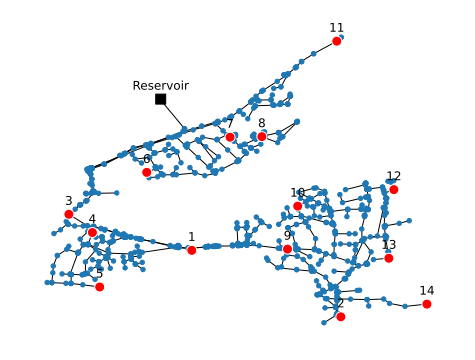

In [7]:
plot_network(wdn, sensor_idx)

### Preliminary model evaluation

Simulate initial (uncalibrated) network hydraulics over 8 days. We first define a function to solve network hydraulics using the `wntr` package, which we used previously in the hyraulic modelling notebook. The following tasks are performed in this function:
- Load network properties
- Modify simulation time to match operational data
- Assign h0 data at model reservoir
- Scale and apply new demand pattern from inflow data
- Option to modify pipe roughness (or HW) coefficients

In [8]:
# define hydraulic solver function
def hydraulic_solver(inp_file, inflow_data, h0_data, C=None, demand=False):

    # load network from wntr
    wn = wntr.network.WaterNetworkModel(inp_file)

    # get network properties
    reservoir_names = wn.reservoir_name_list
    junction_names = wn.junction_name_list
    link_names = wn.link_name_list

    # modify simulation time and hydraulic time step
    nt = h0_data.shape[1]
    wn.options.time.duration = (nt - 1) * 3600
    wn.options.time.hydraulic_timestep = 3600
    wn.options.time.pattern_timestep = 3600
    wn.options.time.report_timestep = 3600

    # assign reservoir data
    for (i, name) in enumerate(reservoir_names):
        wn.add_pattern(f'h0_{i}', h0_data[i])
        reservoir = wn.get_node(name)
        reservoir.head_timeseries.pattern_name = wn.get_pattern(f'h0_{i}')

    # scale demand data
    d_tot = 0
    for name in junction_names:
        node = wn.get_node(name)
        d_tot += node.demand_timeseries_list[0].base_value

    d_pat_vals = [val / d_tot for val in inflow_data]
    d_pat_vals = np.array(d_pat_vals)[0]
    wn.add_pattern('d_pat', d_pat_vals)

    for name in junction_names:
        # don't include boundary valve flows
        if name not in ('node_1809', 'node_1811'):
            node = wn.get_node(name)

            # replace existing demand patterns with scaled version
            for (i, val) in enumerate(node.demand_timeseries_list):
                node.demand_timeseries_list[i].pattern_name = 'd_pat'

    # assign roughness (or HW) coefficients
    if C is not None:
        for name, link in wn.links():
            # check if the link is a pipe
            if isinstance(link, wntr.network.Pipe):
                link.roughness = C[link_names.index(name)]

            # check if link is a valve
            elif isinstance(link, wntr.network.Valve):
                link.minor_loss = C[link_names.index(name)]
                link.initial_setting = C[link_names.index(name)]

    # run simulation and get results
    sim = wntr.sim.EpanetSimulator(wn)
    results = sim.run_sim()

    q_sim = results.link['flowrate'].T
    h_sim = results.node['head'].T
    h_sim = h_sim[~h_sim.index.isin(reservoir_names)] # delete reservoir nodes
    d = results.node['demand'].T
    d = d[~d.index.isin(reservoir_names)] # delete reservoir nodes


    if demand == True:
        return d.to_numpy()
    else:
        return q_sim.to_numpy(), h_sim.to_numpy()

Run simulation with initial `C_0` values.

In [9]:
C_0 = link_df['C'].to_numpy()
_, h_0 = hydraulic_solver(os.path.join(net_dir, net_name), inflow_data, h0_data, C=C_0)

Compare simulated heads at sensor nodes (node indices in `sensor_idx`) with the simulated heads over the 8-day period. Visualise the results with, e.g., a boxplot of pressure residuals on the test dataset or a plot of the network with cumulative pressure residuals at sensor nodes.

Text(0, 0.5, 'Pressure [m]')

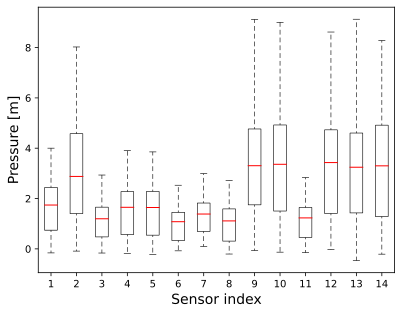

In [10]:
# compute pressure residuals
residuals_0 = h_0[sensor_idx,:] - h_data

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_0.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=14)
ax.set_ylabel('Pressure [m]', fontsize=14)

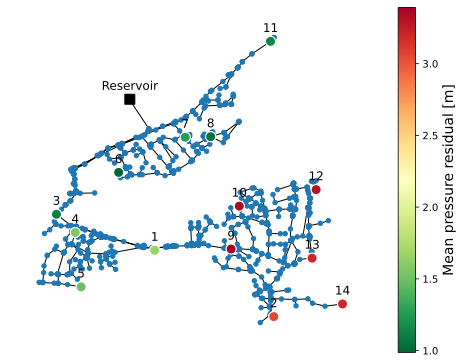

In [11]:
# spatial residuals plot
mean_residuals_0 = np.mean(residuals_0, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_0)

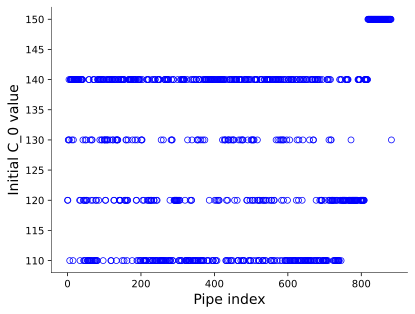

In [12]:
# C_0 value scatter plot (pipes only)
pipe_C = [C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=14)
ax.set_ylabel('Initial C_0 value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
ax.spines[['right', 'top']].set_visible(False)

<u>Question 1:</u> Comment on the results of the preliminary model evaluation. In particular, justify the value of the observed pressure residuals at network sensors. Is the current hydraulic model of STKLnet accurate according to hydraulic model calibration guidelines?

Enter response here...

### Part 1: parameter estimation without pipe grouping/regularisation + valves fixed

Based on the initial comparison between simulated and measured pressures, we propose to calibrate the hydraulic model as an inverse parameter estimation problem. We also want to investigate the effect of regularisation/pipe grouping on the solution of the calibration problem. As a result, Part 1 does NOT include a regularisation term based on pipe grouping and we assume the status of valves is known with minor loss coefficients fixed to C=0.2 (fully open).

Introduce problem formulation and sequential convex programming (SCP) solution method here...

We split the operational data (demand + pressure measurements) into train and test datasets.

In [13]:
# extract model demands
d = hydraulic_solver(os.path.join(net_dir, net_name), inflow_data, h0_data, demand=True)

# tain data
nt_train = 24
data_train = {
    'd': d[:, :nt_train],
    'inflow': inflow_data[:, :nt_train],
    'h0': h0_data[:, :nt_train],
    'h_data': h_data[:, :nt_train]
}

# test data
data_test = {
    'd': d[:, nt_train:],
    'inflow': inflow_data[:, nt_train:],
    'h0': h0_data[:, nt_train:],
    'h_data': h_data[:, nt_train:]
}

The loss function is defined as the mean squared error (MSE) between simulated and measured pressures at sensor locations.

In [14]:
def loss_fun(h, h_data):
    return ( 1/len(h_data.flatten()) ) * np.sum( ( h[sensor_idx, :] - h_data )**2 )

Compute MSE for `C_0` values and training data.

In [15]:
h_0 = h_0[:, :nt_train]
mse_0 = loss_fun(h_0, data_train['h_data'])
mse_0

8.22941305106321

<u>Question 2:</u> Briefly describe the problem of hydraulic model calibration and justify the definition of `loss_fun`.

Enter response here...

Solve parameter estimation problem **without** grouping/regularisation.

In [16]:
# compute matrices for the head loss linear approximation of the HW headloss
def linear_approx_calibration(wdn, q, C):
    # unload data
    A12 = wdn.A12
    A10 = wdn.A10
    net_info = wdn.net_info
    link_df = wdn.link_df

    K = np.zeros((net_info['np'], 1))
    n_exp = link_df['n_exp'].astype(float).to_numpy().reshape(-1, 1)
    b1_k = copy.copy(K)
    b2_k = copy.copy(K)

    for idx, row in link_df.iterrows():
        if row['link_type'] == 'pipe':
            K[idx] = 10.67 * row['length'] * (C[idx] ** -row['n_exp']) * (row['diameter'] ** -4.8704)
            b1_k[idx] = copy.copy(K[idx])
            b2_k[idx] = (-n_exp[idx] * K[idx]) / C[idx]

        elif row['link_type'] == 'valve':
            K[idx] = (8 / (np.pi ** 2 * 9.81)) * (row['diameter'] ** -4) * C[idx]
            b1_k[idx] = -n_exp[idx] * copy.copy(K[idx]) 
            b2_k[idx] = copy.copy(K[idx]) / C[idx]

    a11_k = np.tile(K, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b1_k = np.tile(b1_k, q.shape[1]) * np.abs(q) ** (n_exp - 1)
    b2_k = np.tile(b2_k, q.shape[1]) * np.abs(q) ** (n_exp - 1) * q

    return a11_k, b1_k, b2_k

SCP implementation using `cvxpy` modelling interface.

In [17]:
if model == 'cvxpy':

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T
    inflow = data_train['inflow']

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_up = 200
    C_lo_pipe = 20
    C_lo_valve = 1e-4

    # initialise values
    theta_k = C_0
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data)

    ### main scp code ###
    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])

        # objective function (defined using CVXPY functions)
        loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
        objective = cp.Minimize(loss)

        # hydraulic feasibility constraints
        constraints = []
        for t in range(nt_train):
            # energy and mass constraints
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]

        # variable bounds
        lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
        constraints += lower_bound_pipe
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        constraints += [theta <= C_up]

        # valve minor loss coefficient constraints
        valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += valve_constraints

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
    #     cvx_val = problem.solve(solver=cp.GUROBI, verbose=False)
    #     cvx_val = problem.solve(solver=cp.MOSEK, mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME':100.0, 'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL'}, verbose=False)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data)

        predicted_decrease = objval_k - cvx_val
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-3 or delta_k <= 1e-3:
            break

Iteration 0 successful! Update estimate and increase trust region size. 

0 5.172558883609131 0.371454701384705 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 1.2539578689279003 0.757574945564862 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 1.2539578689279003 0.757574945564862 6.050000000000001 

Iteration 3 successful! Update estimate and increase trust region size. 

3 0.46317820887131234 0.6306269769116589 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.2188810205663497 0.5274367049785739 7.320500000000002 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.21024301065877096 0.03946440803879697 8.052550000000002 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.2046228961700013 0.02673151640646567 8.857805000000003 

Iteration 7 unsuccessful! Return to previous estimate and redu

SCP implementation using `pyomo` modelling interface.

In [18]:
if model == 'pyomo':

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T
    inflow = data_train['inflow']

    # make element maps
    nodes_map = {i: np.where(A12.toarray()[i, :] != 0) for i in range(0, net_info['np'])}
    sources_map = {i: np.where(A10.toarray()[i, :] != 0) for i in range(0, net_info['np'])}
    links_map = {i: np.where(A12.T.toarray()[i, :] != 0) for i in range(0, net_info['nn'])}

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_up = 200
    C_lo_pipe = 20
    C_lo_valve = 1e-4

    # initialise values
    theta_k = C_0
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data)

    ### main scp code ###
    for k in range(iter_max):

        # Pyomo Concrete Model
        model = ConcreteModel()

        # index sets
        model.node_set = RangeSet(0, net_info['nn'] - 1)
        model.pipe_set = RangeSet(0, net_info['np'] - 1)
        model.time_set = RangeSet(0, nt_train - 1)
        model.sensor_set = RangeSet(0, len(sensor_idx) - 1)

        # decision variables
        model.q = Var(model.pipe_set, model.time_set)
        model.h = Var(model.node_set, model.time_set)
        model.theta = Var(model.pipe_set)

        # energy conservation constraints
        def energy_constraints_rule(model, j, t):
            return (
                b1_k[j, t] * q_k[j, t] + n_exp[j] * a11_k[j, t] * model.q[j, t] + b2_k[j, t] * model.theta[j] +
                sum(A12[j, i] * model.h[i, t] for i in nodes_map[j][0]) + sum(A10[j, s] * h0[s, t] for s in sources_map[j][0]) == 0
            )
        model.energy_constraints = Constraint(model.pipe_set, model.time_set, rule=energy_constraints_rule)

        # mass conservation constraints
        def mass_constraints_rule(model, i, t):
            return (
                (sum(A12.T[i, j] * model.q[j, t] for j in links_map[i][0]) == d[i, t])
            )
        model.mass_constraints = Constraint(model.node_set, model.time_set, rule=mass_constraints_rule)

        # trust region constraints
        def trust_region_rule_pos(model, j):
            return (
                model.theta[j] - theta_k[j] <= delta_k
            )
        model.trust_region_pos = Constraint(model.pipe_set, rule=trust_region_rule_pos)
        def trust_region_rule_neg(model, j):
            return (
                -delta_k <= model.theta[j] - theta_k[j]
            )
        model.trust_region_neg = Constraint(model.pipe_set, rule=trust_region_rule_neg)

        # fix valve C values
        def fix_C_valve(model, j):
            if link_df['link_type'][j] == 'valve':
                return (
                    model.theta[j] == C_0[j]
                )
            elif link_df['link_type'][j] == 'pipe':
                return (
                    Constraint.Skip
                )
        model.fix_C_valve = Constraint(model.pipe_set, rule=fix_C_valve)

        # C lower bound
        def C_lo_bound(model, j):
            if link_df['link_type'][j] == 'valve':
                return (
                    model.theta[j] >= C_lo_valve
                )
            elif link_df['link_type'][j] == 'pipe':
                return (
                    model.theta[j] >= C_lo_pipe
                )
        model.C_lo_bound = Constraint(model.pipe_set, rule=C_lo_bound)

        # C upper bound
        def C_up_bound(model, j):
            return (
                model.theta[j] <= C_up
            )
        model.C_up_bound = Constraint(model.pipe_set, rule=C_up_bound)


        # objective function
        def loss_rule(model):
            return (
                (1 / (len(h_data.flatten()))) * sum(sum((model.h[sensor_idx[i], t] - h_data[i, t])**2 for i in model.sensor_set) for t in model.time_set)
            )
        model.loss = Objective(rule=loss_rule, sense=minimize)


        # solve optimisation problem
    #     solver = SolverFactory('gurobi')
    #     solver.options['method'] = 2
    #     solver.options['presolve'] = 0
    #     solver.options['crossover'] = 0
    #     solver.options['numericfocus'] = 2
    #     solver = SolverFactory('mosek', mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME':100.0, 'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL'})
        solver = SolverFactory('ipopt')
    #     solver = SolverFactory('appsi_highs')
        results = solver.solve(model)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = np.array([value(model.theta[j]) for j in model.pipe_set])
        obj_pyomo = value(model.loss)
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data)

        predicted_decrease = objval_k - obj_pyomo
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-3 or delta_k <= 1e-3:
            break

Results plotting.

Text(0, 0.5, 'Pressure [m]')

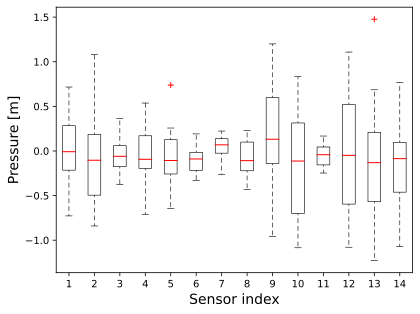

In [19]:
C_1 = theta_k
# compute hydraulics
_, h_1 = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=C_1)

# compute pressure residuals
residuals_1 = h_1[sensor_idx,:] - data_train['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_1.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=14)
ax.set_ylabel('Pressure [m]', fontsize=14)

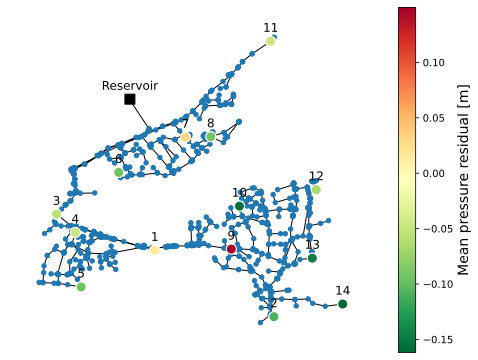

In [20]:
# spatial residuals plot
mean_residuals_1 = np.mean(residuals_1, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_1)

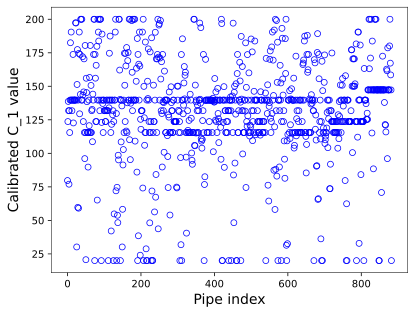

In [21]:
# C_1 value scatter plot (pipes only)
pipe_C = [C_1[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=14)
ax.set_ylabel('Calibrated C_1 value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

<u>Question 2:</u> Comment on the results of the model calibration without grouping/regularisation. In particular, discuss the calibrated `c_1` values. Are these realistic?

Enter response here...

### Part 2: parameter estimation with pipe grouping/regularisation + valves fixed

Load pipe grouping information.

In [22]:
link_groups = data['G']
ng = link_groups.shape[1]

Define regularisation term to add in the loss function.

In [23]:
pipe_idx = link_df.index[link_df['link_type'] == 'pipe'].tolist()
gamma = 10 # hyperparameter of l2 refularisation term

def reg_fun(theta, thetaG):
    return gamma * np.sum((theta[j] - link_groups[j, :] @ thetaG)**2 for j in pipe_idx)

Main SCP code with pipe grouping/regularisation term.

In [24]:
if model == 'cvxpy':

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T
    inflow = data_train['inflow']

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_up = 200
    C_lo_pipe = 20
    C_lo_valve = 0
    thetaG_lo = data['thetaG_min']
    thetaG_up = data['thetaG_max']

    # initialise values
    theta_k = C_0
    thetaG_k = thetaG_lo + (thetaG_up - thetaG_lo) / 2
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data) + reg_fun(theta_k, thetaG_k)

    ### main scp code ###
    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])
        thetaG = cp.Variable(ng)

        # objective function (defined using CVXPY functions)
        loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
        reg = 0
        for j in pipe_idx:
            reg += gamma * (theta[j] - cp.matmul(link_groups[j, :], thetaG))**2
            
        objective = cp.Minimize(loss + reg)

        # hydraulic feasibility constraints
        constraints = []
        for t in range(nt_train):
            # energy and mass constraints
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]

        # C bounds
        lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
        constraints += lower_bound_pipe
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        constraints += [theta <= C_up]
        
        # thetaG bounds (pipe groupings)
        constraints += [
            thetaG >= thetaG_lo,
            thetaG <= thetaG_up
        ]

        # valve minor loss coefficient constraints
        valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += valve_constraints

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
    #     cvx_val = problem.solve(solver=cp.GUROBI, verbose=False)
    #     cvx_val = problem.solve(solver=cp.MOSEK, mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME':100.0, 'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL'}, verbose=False)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        thetaG_tilde = thetaG.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data) + reg_fun(theta_tilde, thetaG_tilde)

        predicted_decrease = objval_k - cvx_val
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            thetaG_k = thetaG_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-3 or delta_k <= 1e-3:
            break

Iteration 0 successful! Update estimate and increase trust region size. 

0 485006.5172528635 0.9465833953354055 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 4.62909974881469 0.9999904555926897 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 3.8301301176115756 0.1725971948233986 26.620000000000005 

Iteration 3 successful! Update estimate and increase trust region size. 

3 3.6999184372414424 0.03399667279484794 29.282000000000007 

Iteration 4 unsuccessful! Return to previous estimate and reduce trust region size. 

4 3.6999184372414424 0.03399667279484794 7.320500000000002 

Iteration 5 unsuccessful! Return to previous estimate and reduce trust region size. 

5 3.6999184372414424 0.03399667279484794 1.8301250000000004 

Iteration 6 unsuccessful! Return to previous estimate and reduce trust region size. 

6 3.6999184372414424 0.03399667279484794 0.4575312500000001 

Iteration 7 unsuccessful! Return 

Results plotting.

Text(0, 0.5, 'Pressure [m]')

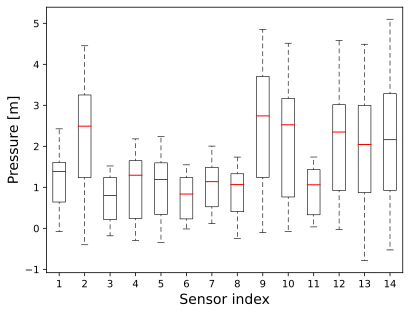

In [25]:
C_2 = theta_k
# compute hydraulics
_, h_2 = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=C_2)

# compute pressure residuals
residuals_2 = h_2[sensor_idx,:] - data_train['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_2.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=14)
ax.set_ylabel('Pressure [m]', fontsize=14)

In [44]:
mse_2 = loss_fun(h_2, h_data)
mse_2

3.6998880871445405

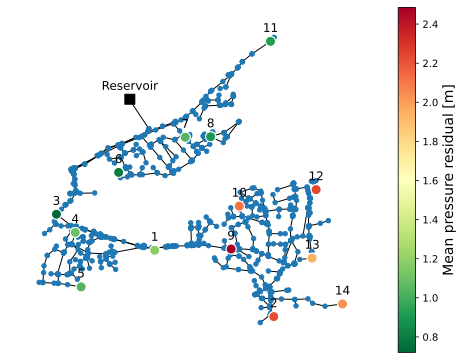

In [26]:
# spatial residuals plot
mean_residuals_2 = np.mean(residuals_2, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_2)

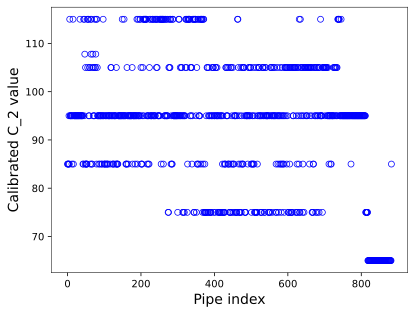

In [27]:
# C_2 value scatter plot (pipes only)
pipe_C = [C_2[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=14)
ax.set_ylabel('Calibrated C_2 value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

<u>Question 3:</u> Comment on the results of the model calibration with grouping/regularisation. In particular, discuss the calibrated `c_2` values.

Enter response here...

### Part 3: parameter estimation with pipe grouping/regularisation + valve coefficients

The H-W coefficients in `C_2` (obtained by solving the parameter estimation with grouping/regularisation) result in larger residuals between measured and simulated pressures. Large, localised deviations between measured and simulated pressures can occur as the result of unknown changes in the network (or faults), such as unknowingly closed valves for instance. In particular, faults associated with unknown valve status can be located by solving a model calibration problem where valve loss coefficients are, this time, free to vary. 
In this part of the coursework, you are encouraged to propose and investigate an approach to solving the **single** fault localisation problem. You may follow the suggested steps below

Approach to solving the fault localisation problem:
1. Try modifying the CVX implementation of the regularised hydraulic model calibration problem to allow loss coefficient estimates corresponding to valves to vary. Solve the resulting problem and interpret the optimal value of `C_3`.
2. Consider the expected values of valve loss coefficient estimates `C_3` in the single fault localisation problem. Try modifying the CVX implementation by including another regularisation term in the objective function to account for the nature of the single fault localisation problem and interpret your results in the light of the modified problem formulation.

#### Part 3a: free valve coefficients

In [28]:
if model == 'cvxpy':

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T
    inflow = data_train['inflow']

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_up = 200
    C_lo_pipe = 20
    C_lo_valve = 0
    thetaG_lo = data['thetaG_min']
    thetaG_up = data['thetaG_max']

    # initialise values
    theta_k = C_0
    thetaG_k = thetaG_lo + (thetaG_up - thetaG_lo) / 2
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data) + reg_fun(theta_k, thetaG_k)

    ### main scp code ###
    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])
        thetaG = cp.Variable(ng)

        # objective function (defined using CVXPY functions)
        loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
        reg = 0
        for j in pipe_idx:
            reg += gamma * (theta[j] - cp.matmul(link_groups[j, :], thetaG))**2
            
        objective = cp.Minimize(loss + reg)

        # hydraulic feasibility constraints
        constraints = []
        for t in range(nt_train):
            # energy and mass constraints
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]

        # C bounds
        lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
        constraints += lower_bound_pipe
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        constraints += [theta <= C_up]
        
        # thetaG bounds (pipe groupings)
        constraints += [
            thetaG >= thetaG_lo,
            thetaG <= thetaG_up
        ]

#         # valve minor loss coefficient constraints
#         valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
#         constraints += valve_constraints

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
    #     cvx_val = problem.solve(solver=cp.GUROBI, verbose=False)
    #     cvx_val = problem.solve(solver=cp.MOSEK, mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME':100.0, 'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL'}, verbose=False)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        thetaG_tilde = thetaG.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data) + reg_fun(theta_tilde, thetaG_tilde)

        predicted_decrease = objval_k - cvx_val
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            thetaG_k = thetaG_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-3 or delta_k <= 1e-3:
            break

Iteration 0 successful! Update estimate and increase trust region size. 

0 485000.40260539675 0.9465840687772971 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 0.19253948534313672 0.9999996030117 24.200000000000003 

Iteration 2 unsuccessful! Return to previous estimate and reduce trust region size. 

2 0.19253948534313672 0.9999996030117 6.050000000000001 

Iteration 3 successful! Update estimate and increase trust region size. 

3 0.18924790133584843 0.017095631067166075 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.18816853834576736 0.0057034343972226335 7.320500000000002 

Iteration 5 successful! Update estimate and increase trust region size. 

5 0.18738529229457884 0.004162470825751256 8.052550000000002 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.1861795099878141 0.0064347756005801796 8.857805000000003 

Iteration 7 successful! Update estimate and increase 

Results plotting.

Text(0, 0.5, 'Pressure [m]')

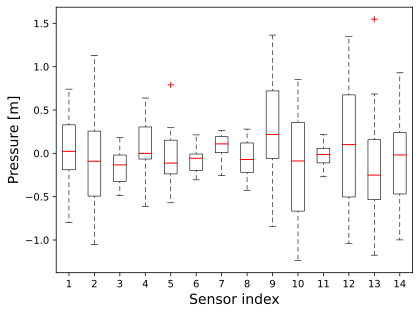

In [29]:
C_3a = theta_k
# compute hydraulics
_, h_3a = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=C_3a)

# compute pressure residuals
residuals_3a = h_3a[sensor_idx,:] - data_train['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3a.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=14)
ax.set_ylabel('Pressure [m]', fontsize=14)

In [42]:
mse_3a = loss_fun(h_3a, h_data)
mse_3a

0.18436366850001523

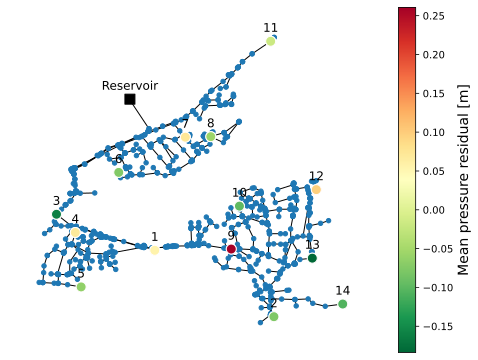

In [30]:
# spatial residuals plot
mean_residuals_3a = np.mean(residuals_3a, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3a)

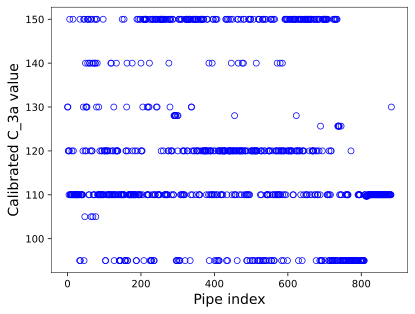

In [31]:
# C_3a value scatter plot (pipes)
pipe_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=14)
ax.set_ylabel('Calibrated C_3a value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

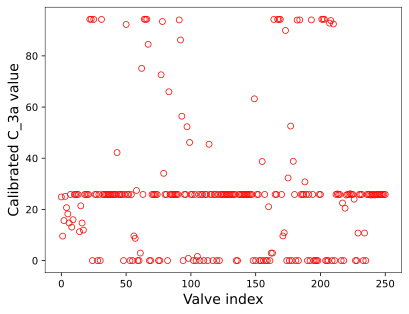

In [32]:
# C_3a value scatter plot (valves)
valve_C = [C_3a[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=14)
ax.set_ylabel('Calibrated C_3a value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

Discuss results....

#### Part 3b: free valve coefficients + L1-norm regularisation

Define L-1 norm regularisation term.

In [33]:
valve_idx = link_df.index[link_df['link_type'] == 'valve'].tolist()
rho = 1e-1
def valve_reg_fun(theta):
    return rho * (1 / len(valve_idx)) * la.norm(C_0[valve_idx] - theta[valve_idx], 1)

Main SCP code.

In [34]:
if model == 'cvxpy':

    # unload network training data
    n_exp = link_df['n_exp']
    d = data_train['d']
    h_data = data_train['h_data']
    h0 = data_train['h0'].reshape(-1, 1).T
    inflow = data_train['inflow']

    # define problem parameters
    Ki = np.inf 
    iter_max = 50
    delta_k = 20
    C_up = 200
    C_lo_pipe = 20
    C_lo_valve = 0
    thetaG_lo = data['thetaG_min']
    thetaG_up = data['thetaG_max']

    # initialise values
    theta_k = C_0
    thetaG_k = thetaG_lo + (thetaG_up - thetaG_lo) / 2
    q_k, h_k = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_k)
    a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
    objval_k = loss_fun(h_k, h_data) + reg_fun(theta_k, thetaG_k) + valve_reg_fun(theta_k)

    ### main scp code ###
    for k in range(iter_max):

        # decision variables
        q = cp.Variable((net_info['np'], nt_train))
        h = cp.Variable((net_info['nn'], nt_train))
        theta = cp.Variable(net_info['np'])
        thetaG = cp.Variable(ng)

        # objective function (defined using CVXPY functions)
        loss = ( 1/len(h_data.flatten()) ) * cp.sum_squares( h[sensor_idx,:] - h_data )
        reg = 0
        for j in pipe_idx:
            reg += gamma * (theta[j] - cp.matmul(link_groups[j, :], thetaG))**2
        valve_reg = rho * (1 / len(valve_idx)) * cp.norm(C_0[valve_idx] - theta[valve_idx], 1)
            
        objective = cp.Minimize(loss + reg + valve_reg)

        # hydraulic feasibility constraints
        constraints = []
        for t in range(nt_train):
            # energy and mass constraints
            constraints += [
                cp.multiply(b1_k[:, t], q_k[:, t]) + cp.multiply(cp.multiply(n_exp, a11_k[:, t]), q[:, t]) + cp.multiply(b2_k[:, t], theta) + A12 @ h[:, t] + A10 @ h0[:, t] == 0,
                A12.T @ q[:, t] == d[:, t]
            ]

        # trust region constraints
        constraints += [
            cp.norm(theta - theta_k, 'inf') <= delta_k
        ]

        # C bounds
        lower_bound_pipe = [theta[idx] >= C_lo_pipe for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
        constraints += lower_bound_pipe
        lower_bound_valve = [theta[idx] >= C_lo_valve for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
        constraints += lower_bound_valve
        constraints += [theta <= C_up]
        
        # thetaG bounds (pipe groupings)
        constraints += [
            thetaG >= thetaG_lo,
            thetaG <= thetaG_up
        ]

#         # valve minor loss coefficient constraints
#         valve_constraints = [theta[idx] == C_0[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
#         constraints += valve_constraints

        # solve optimisation problem
        problem = cp.Problem(objective, constraints)
    #     cvx_val = problem.solve(solver=cp.GUROBI, verbose=False)
    #     cvx_val = problem.solve(solver=cp.MOSEK, mosek_params={'MSK_DPAR_OPTIMIZER_MAX_TIME':100.0, 'MSK_IPAR_INTPNT_SOLVE_FORM':'MSK_SOLVE_DUAL'}, verbose=False)
        cvx_val = problem.solve(solver=cp.ECOS, verbose=False)

        # store optimal solution and compute actual and predicted decrease in objval
        theta_tilde = theta.value
        thetaG_tilde = thetaG.value
        [q_tilde, h_tilde] = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=theta_tilde)
        objval_tilde = loss_fun(h_tilde, h_data) + reg_fun(theta_tilde, thetaG_tilde) + valve_reg_fun(theta_tilde)

        predicted_decrease = objval_k - cvx_val
        actual_decrease = objval_k - objval_tilde

        # evaluate latest SCP iteration
        if actual_decrease / predicted_decrease >= 0.1:
            objval_old = objval_k
            theta_k = theta_tilde
            thetaG_k = thetaG_tilde
            q_k = q_tilde
            h_k = h_tilde
            objval_k = objval_tilde
            a11_k, b1_k, b2_k = linear_approx_calibration(wdn, q_k, theta_k)
            Ki = np.abs(objval_old - objval_k) / np.abs(objval_old)
            delta_k = 1.1 * delta_k
            print(f"Iteration {k} successful! Update estimate and increase trust region size. \n")

        else:
            delta_k = 0.25 * delta_k
            print(f"Iteration {k} unsuccessful! Return to previous estimate and reduce trust region size. \n")

        print(f"{k} {objval_k} {Ki} {delta_k} \n")

        if Ki <= 1e-3 or np.abs(objval_k) <= 1e-3 or delta_k <= 1e-3:
            break

Iteration 0 successful! Update estimate and increase trust region size. 

0 485000.7044776507 0.94658403553034 22.0 

Iteration 1 successful! Update estimate and increase trust region size. 

1 0.2910829655632702 0.9999993998298088 24.200000000000003 

Iteration 2 successful! Update estimate and increase trust region size. 

2 0.2635720755158045 0.09451219515449745 26.620000000000005 

Iteration 3 unsuccessful! Return to previous estimate and reduce trust region size. 

3 0.2635720755158045 0.09451219515449745 6.655000000000001 

Iteration 4 successful! Update estimate and increase trust region size. 

4 0.2619851757274405 0.006020743226529172 7.320500000000002 

Iteration 5 unsuccessful! Return to previous estimate and reduce trust region size. 

5 0.2619851757274405 0.006020743226529172 1.8301250000000004 

Iteration 6 successful! Update estimate and increase trust region size. 

6 0.2618634386172889 0.0004646717502759446 2.0131375000000005 



Results plotting.

Text(0, 0.5, 'Pressure [m]')

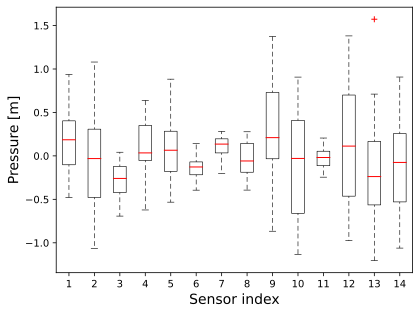

In [35]:
C_3b = theta_k
# compute hydraulics
_, h_3b = hydraulic_solver(os.path.join(net_dir, net_name), inflow, h0, C=C_3b)

# compute pressure residuals
residuals_3b = h_3b[sensor_idx,:] - data_train['h_data']

# create a figure and axis for the box plots
fig, ax = plt.subplots()
boxplot = ax.boxplot(residuals_3b.T, medianprops=dict(color="red", linewidth=1.0), flierprops=dict(marker="+", markeredgecolor="red"), whiskerprops=dict(linestyle=(5, (8, 5)), linewidth=0.6), boxprops=dict(color='black', linewidth=0.6), capprops=dict(linewidth=0.6))
ax.set_xlabel('Sensor index', fontsize=14)
ax.set_ylabel('Pressure [m]', fontsize=14)

In [43]:
mse_3b = loss_fun(h_3b, h_data)
mse_3b

0.19819586945587578

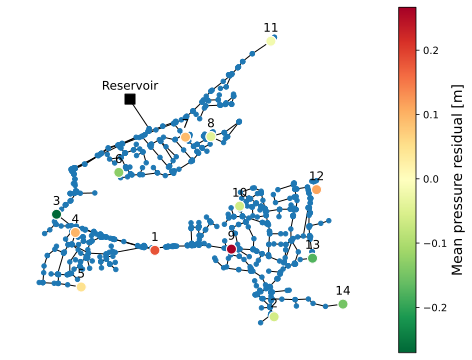

In [36]:
# spatial residuals plot
mean_residuals_3b = np.mean(residuals_3b, axis=1)
plot_network(wdn, sensor_idx, vals=mean_residuals_3b)

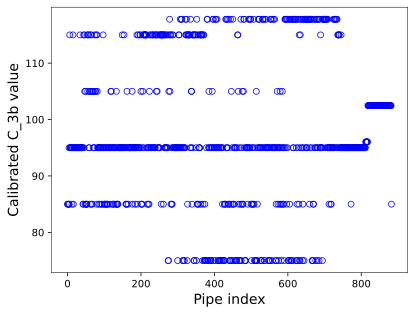

In [37]:
# C_3b value scatter plot (pipes)
pipe_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'pipe']
fig, ax = plt.subplots()
ax.scatter(range(len(pipe_C)), pipe_C, facecolors='none', edgecolors='b',linewidths=0.75)
ax.set_xlabel('Pipe index', fontsize=14)
ax.set_ylabel('Calibrated C_3b value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

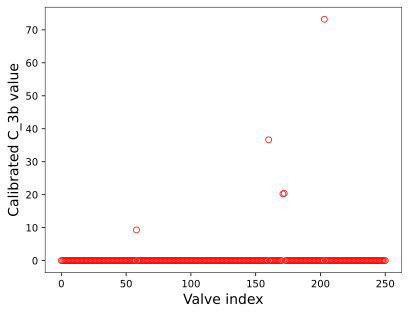

In [38]:
# C_3b value scatter plot (valves)
valve_C = [C_3b[idx] for idx, row in link_df.iterrows() if row['link_type'] == 'valve']
fig, ax = plt.subplots()
ax.scatter(range(len(valve_C)), valve_C, facecolors='none', edgecolors='r',linewidths=0.75)
ax.set_xlabel('Valve index', fontsize=14)
ax.set_ylabel('Calibrated C_3b value', fontsize=14)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(0.5)
# ax.spines[['right', 'top']].set_visible(False)

Plot faulty valve locations.

In [39]:
# find indices of faulty valves and corresponding downstream nodes
valve_C = [idx for idx in valve_idx if C_3b[idx] > 1]
valve_nodes = link_df.loc[valve_C, 'node_out'].tolist()

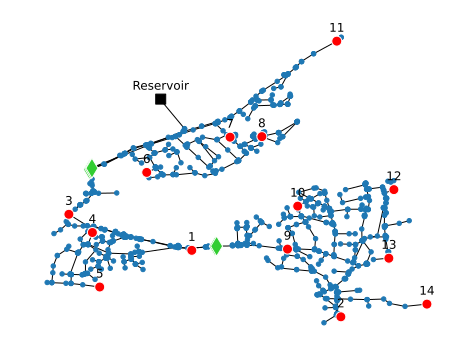

In [40]:
plot_network(wdn, sensor_idx, highlight_valves=valve_nodes)

Discuss results...